In [24]:
import sys
import os
from pathlib import Path
import pandas as pd
import sys

import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
generated_series_path = Path(parent_dir) / 'generated_series'
figure_save_path = Path(parent_dir) / 'figures'
if not figure_save_path.exists():
    os.makedirs(figure_save_path)

import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from models.ICL import MultiResolutionPDF
import sys
import torch
sys.path.append("../models")

def Markov_BT_loss(series_dict, temperature = 1):
    logit_mat_good = series_dict['logit_mat_good']
    probs = torch.nn.functional.softmax(logit_mat_good / temperature, dim=-1)
    P = series_dict['P']
    full_array = series_dict['full_array']
    N_state = P.shape[0]
    states = np.arange(N_state)
    start_idx = 0
    loss_array = np.zeros(full_array[start_idx:].squeeze().shape)
    for state in states:
        ### add 2 to slice out BOS
        pos = np.where(full_array[start_idx:]==state)[0]+2
        learned_p_out = probs.squeeze()[start_idx:][pos]
        true_p_out = torch.tensor(P[state])
        ### Bhattacharyya distance at each row
        sqrt_PQ = torch.sum(torch.sqrt(learned_p_out * true_p_out), dim = 1)
        BH_dist = -torch.log(sqrt_PQ)
        dist = BH_dist
        loss_array[pos-2] = dist.numpy()
    
    window_size = 20
    top_hat_kernel = np.ones(window_size) / window_size
    averaged_loss = np.convolve(loss_array, top_hat_kernel, mode='valid')
    x_range = np.arange(window_size//2, len(loss_array) - window_size//2 + 1)
    return x_range, averaged_loss
    
def Gaussian_BT_loss(processed_dict):
    rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
    rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
    predicted_mean_arr = processed_dict['predicted_mean_arr']
    predicted_sigma_arr = processed_dict['predicted_sigma_arr'] 
    analytic_BT_loss = []
    analytic_mean_loss = []
    for true_mean, true_sigma, pred_mean, pred_sigma in zip(rescaled_true_mean_arr, 
                                                            rescaled_true_sigma_arr,
                                                            predicted_mean_arr,
                                                            predicted_sigma_arr):
        BT_dist = (true_mean-pred_mean)**2 / (true_sigma**2 + pred_sigma**2)/4 + np.log((true_sigma**2 + pred_sigma**2)/(2 * true_sigma * pred_sigma))/2
        mean_loss = np.abs(true_mean-pred_mean)
        analytic_BT_loss += [BT_dist]
        analytic_mean_loss += [mean_loss]
           
    analytic_BT_loss = np.array(analytic_BT_loss)
    analytic_mean_loss = np.array(analytic_mean_loss)
         
    window_size = 10
    top_hat_kernel = np.ones(window_size) / window_size
    averaged_BT_loss = np.convolve(analytic_BT_loss, top_hat_kernel, mode='valid')
    averaged_mean_loss = np.convolve(analytic_mean_loss, top_hat_kernel, mode='valid')
    x_range = np.arange(window_size//2, len(analytic_BT_loss) - window_size//2 + 1)
    return x_range, averaged_mean_loss, averaged_BT_loss         
    
def BT_mean_loss(processed_dict, temperature = 1):
    full_series = processed_dict['full_series']
    rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
    rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
    llama_size = processed_dict['llama_size']
    mode = processed_dict['mode']
    refine_depth = processed_dict['refine_depth']
    random_seed = processed_dict['random_seed']
    PDF_list = processed_dict['PDF_list']
    time_series = processed_dict['time_series']
    prec = processed_dict['prec']
    PDF_list = copy.deepcopy(PDF_list)
    for PDF in PDF_list:
        if temperature != 1:
            PDF.rescale_temperature(temperature)
    ### Calculate true discretized distribution: PDF_list_true
    ### Compute discretized BT and KL loss

    PDF_true_list = copy.deepcopy(PDF_list)
    discrete_BT_loss = []
    # discrete_KL_loss = []
    for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
        def cdf(x):
            return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))

        PDF_true.discretize(cdf, mode = "cdf")
        PDF_true.compute_stats()
        discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
        # discrete_KL_loss += [PDF_true.KL_div(PDF)]

    discrete_BT_loss = np.array(discrete_BT_loss)
    # discrete_KL_loss = np.array(discrete_KL_loss)

    ### Extract statistics from MultiResolutionPDF

    mean_arr = []
    mode_arr = []
    sigma_arr = []
    moment_3_arr = []
    moment_4_arr = []

    num_commas = full_series.count(',')
    for comma_idx in range(num_commas):
        PDF_list[comma_idx].compute_stats()
        mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
        moment_3 = PDF_list[comma_idx].compute_moment(3)
        moment_4 = PDF_list[comma_idx].compute_moment(4)
        
        mean_arr.append(mean)
        mode_arr.append(mode)
        sigma_arr.append(sigma)
        moment_3_arr.append(moment_3)
        moment_4_arr.append(moment_4)

    # Convert lists to numpy arrays
    mean_arr = np.array(mean_arr)
    mode_arr = np.array(mode_arr)
    sigma_arr = np.array(sigma_arr)
    moment_3_arr = np.array(moment_3_arr)
    moment_4_arr = np.array(moment_4_arr)

    error_mean = np.abs(rescaled_true_mean_arr - mean_arr)
    
    window_size = 10

    top_hat_kernel = np.ones(window_size) / window_size
    gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
    # kernel = gaussian_kernel
    kernel = top_hat_kernel        
    averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')
    averaged_discrete_BT_loss = np.convolve(discrete_BT_loss, kernel, mode='valid')
    x_range = np.arange(window_size//2, len(discrete_BT_loss) - window_size//2 + 1)
    return(x_range, averaged_error_mean, averaged_discrete_BT_loss)


def experiment_plotter(series_name, xlog, ylog, plot_mean, processed_series, legend = False, temperature = 1):
    BT_loss_list = []
    mean_loss_list = []
    avg_mean_loss = None
    avg_BT_loss = None

    fig, ax1 = plt.subplots(figsize=(8, 3))
    axs = [ax1]
    if plot_mean:
        ax2 = ax1.twinx()
        axs += [ax2]
        
    if xlog:
        for ax in axs:
            ax.set_xscale('log')
        
    if ylog:
        for ax in axs:
            ax.set_yscale('log')    
    
    for series_dict in processed_series[series_name]:
        # plot_title = f"random_seed: {series_dict['random_seed']}, prec: {series_dict['prec']}, refine_depth: {series_dict['refine_depth']}, mode: {series_dict['mode']}"
        # print(plot_title)
        if series_name[-3:] == 'AR1':
            x_range, mean_loss, BT_loss = Gaussian_BT_loss(series_dict)   
            print(x_range.shape, mean_loss.shape, BT_loss.shape)   
        elif series_name[:len('markov_chain')] == 'markov_chain':
            x_range, BT_loss = Markov_BT_loss(series_dict, temperature = temperature)
            BT_loss_list += [BT_loss]
        else:            
            x_range, mean_loss, BT_loss = BT_mean_loss(series_dict, temperature = temperature)
            BT_loss_list += [BT_loss]
            mean_loss_list += [mean_loss] 
            print(x_range.shape, mean_loss.shape, BT_loss.shape) 
            
        if plot_mean:
            ax2.spines['right'].set_color('blue')
            ax2.yaxis.label.set_color('blue')
            ax2.tick_params(axis='y', colors='blue') 
            ax2.set_ylabel("Squared Deviation from the Mean")               
        
        
        if legend:
            if series_name in ['markov_chain_70b', 'markov_chain_13b']:
                n_states = series_dict['P'].shape[0]
                color_map = plt.get_cmap('viridis')
                # Normalize n_states to range between 0 and 1 for color mapping
                normalized_n_states = (n_states - 4) / (10 - 4)
                ax1.plot(x_range, BT_loss, linewidth=2, alpha=0.8, label=f"{n_states} states", color=color_map(normalized_n_states))
            else:
                # Add label only for the first trajectory
                if len(BT_loss_list) == 1:
                    ax1.plot(x_range, BT_loss, linewidth=2, c='black', alpha = 0.1, label = "individual loss")
                    if plot_mean:
                        ax2.plot(x_range, mean_loss, linewidth=2, c='blue', alpha = 0.1, label = "individual loss")
                else:
                    ax1.plot(x_range, BT_loss, linewidth=2, c='black', alpha = 0.1)
                    if plot_mean:
                        ax2.plot(x_range, mean_loss, linewidth=2, c='blue', alpha = 0.1)

                   
        else:
            ax1.plot(x_range, BT_loss, linewidth=2, c='black', alpha = 0.1)
            if plot_mean: 
                ax2.plot(x_range, mean_loss, linewidth=2, c='blue', alpha = 0.1)
   


        
    avg_BT_loss = np.mean(BT_loss_list, axis=0)
    
    if legend:
        if series_name not in ['markov_chain_70b', 'markov_chain_13b']:
            ax1.plot(x_range, avg_BT_loss , linewidth=2, c='black', alpha = 0.7, label = "average loss")
            print(x_range.shape, avg_BT_loss.shape)
        if plot_mean:
            avg_mean_loss = np.mean(mean_loss_list, axis=0)
            ax2.plot(x_range, avg_mean_loss , linewidth=2, c='blue', alpha = 0.7, label = "average loss")
    else:
        ax1.plot(x_range, avg_BT_loss , linewidth=2, c='black', alpha = 0.7)
        if plot_mean:
            avg_mean_loss = np.mean(mean_loss_list, axis=0)
            ax2.plot(x_range, avg_mean_loss , linewidth=2, c='blue', alpha = 0.7)
        
    # if legend and series_name != 'markov_chain':
    #     ax1.plot(x_range, BT_loss, linewidth=2, alpha = 0.6, label = f"single trajectory loss")   
    
    ax1.set_ylabel("Bhattacharyya distance")
    ax1.set_xlabel("context length")
    ax1.set_xlim(0,1000)
        
    # if legend and series_name != 'markov_chain':
    #     ax1.plot(x_range, BT_loss, linewidth=2, alpha = 0.6, label = f"single trajectory loss")
    

    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.title(f"in-context loss for learning {series_name.replace('_', ' ')}")
    print(f"number of trajectories: {len(BT_loss_list)}")
    if legend:
        ax1.legend(loc='upper right')
        # if plot_mean:
        #     ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.8))
    return x_range, avg_mean_loss, avg_BT_loss

In [25]:
### load all series
processed_series_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
generated_series_files = sorted([path for path in generated_series_path.iterdir()], key=lambda x: x.name)
  
all_series = {}
processed_series = {}
for idx, file in enumerate(generated_series_files):
    series_name = file.name.rsplit('_', 1)[0]
    if series_name not in all_series:
        all_series[series_name] = []
        processed_series[series_name] = []
    series_dict = pickle.load(file.open('rb'))
    series_dict['series_name'] = file.name[:-4]
    corresponding_processed_file = next((processed_file for processed_file in processed_series_files if processed_file.name == file.name), None)
    if corresponding_processed_file is not None:
        processed_dict = pickle.load(corresponding_processed_file.open('rb'))
        series_dict['processed?'] = "yes" 
        # print(series_dict['series_name'])
        # print(processed_dict.keys())
        # break
        processed_dict["series_name"] = file.name[:-4]
        processed_series[series_name] += [processed_dict]
    else:
        series_dict['processed?'] = 'no'
    all_series[series_name] += [series_dict]
    

# Create a DataFrame to store the series data
series_df = pd.DataFrame(columns=['Name', 'Random Seed', 'Precision', 'Mode', 'refine_depth', '# states', 'llama_size', 'processed?'])

for key, series_list in all_series.items():
    if key == 'markov_chain':
        for series in series_list:
            # Append the series data to the DataFrame
            new_row = pd.DataFrame({'Name': [series['series_name']], 
                                    'Random Seed': [series['random_seed']], 
                                    'Precision': ["NA"], 
                                    'Mode': ["NA"],
                                    'refine_depth': ["NA"],
                                    '# states': [series['P'].shape[0]],
                                    'llama_size': [series['llama_size']],
                                    'processed?': [series['processed?']]})
            # Explicitly cast to bool dtype to avoid FutureWarning
            series_df = pd.concat([series_df, new_row], ignore_index=True)
    else:
        for series in series_list:
            # Append the series data to the DataFrame
            new_row = pd.DataFrame({'Name': [series['series_name']], 
                                    'Random Seed': [series['random_seed']], 
                                    'Precision': [series['prec']], 
                                    'Mode': [series['mode']],
                                    'refine_depth': [series['refine_depth']],
                                    '# states': ['NA'],
                                    'llama_size': [series['llama_size']],
                                    'processed?': [series['processed?']]})
            # Explicitly cast to bool dtype to avoid FutureWarning
            series_df = pd.concat([series_df, new_row], ignore_index=True)

# Print the DataFrame without the index
print(series_df.to_string(index=False))

processed_series_for_appendix = processed_series.copy()
processed_series_for_baseline = processed_series.copy()


                        Name Random Seed Precision     Mode refine_depth # states llama_size processed?
           brownian_motion_0           5         3 neighbor            2       NA        13b        yes
           brownian_motion_1           6         3 neighbor            2       NA        13b        yes
          brownian_motion_10          13         3 neighbor            2       NA        13b        yes
          brownian_motion_11          14         3 neighbor            2       NA        13b        yes
          brownian_motion_12           7         2      all            1       NA        13b        yes
          brownian_motion_13           8         2      all            1       NA        13b        yes
          brownian_motion_14           9         2      all            1       NA        13b        yes
          brownian_motion_15          10         2      all            1       NA        13b        yes
          brownian_motion_16          11         2      all     

In [10]:
### Choose type of trajectories to keep

for series_type, series_list in processed_series.items():
    if series_type == 'geometric_brownian_motion':
        processed_series[series_type] = [series_dict for series_dict in series_list if series_dict['prec'] == 3]
        
    # elif series_type == 'markov_chain':
    #     processed_series[series_type] = [series_dict for series_dict in series_list if series_dict['prec'] == 2]
    elif series_type == 'lorenz_system':
        # processed_series[series_type] = [series_dict for series_dict in series_list if series_dict['refine_depth'] == 0]
        processed_series[series_type] = [series_dict for series_dict in series_list if series_dict['llama_size'] == "13b"]        
        
    elif series_type == 'markov_chain':
        processed_series_for_baseline['markov_chain_llama_13b'] = [series_dict for series_dict in series_list if series_dict['P'].shape[0] == 4 and series_dict['llama_size'] == "13b"]
        processed_series_for_baseline['markov_chain_unigram'] = [series_dict for series_dict in series_list if series_dict['P'].shape[0] == 4 and series_dict['llama_size'] == "unigram"]
        processed_series_for_baseline['markov_chain_bigram'] = [series_dict for series_dict in series_list if series_dict['P'].shape[0] == 4 and series_dict['llama_size'] == "bigram"]

    elif series_type == 'noisy_logistic_map':
        processed_series_for_baseline['noisy_logistic_map_llama'] = [series_dict for series_dict in series_list if series_dict['llama_size'] == "13b"]
        processed_series_for_baseline['noisy_logistic_map_AR1'] = [series_dict for series_dict in series_list if series_dict['llama_size'] == "AR1"]
fig_1_series = {}

### Plots for appendix

### Plots for main text

number of trajectories: 10


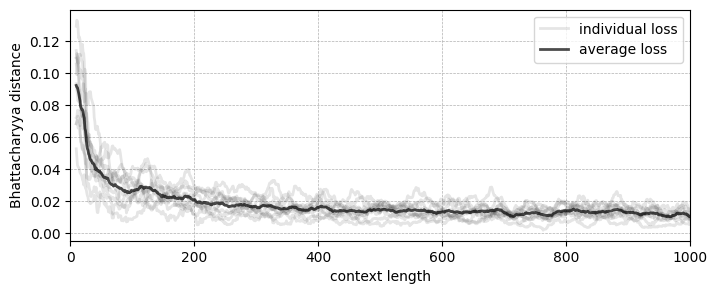

In [13]:
series_name = 'markov_chain_llama_13b'
x_range, avg_mean_loss, avg_BT_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 0,
                   processed_series=processed_series_for_baseline, legend = True)

fig_1_series[series_name] = (x_range[:1000], avg_BT_loss[:1000])
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

number of trajectories: 9


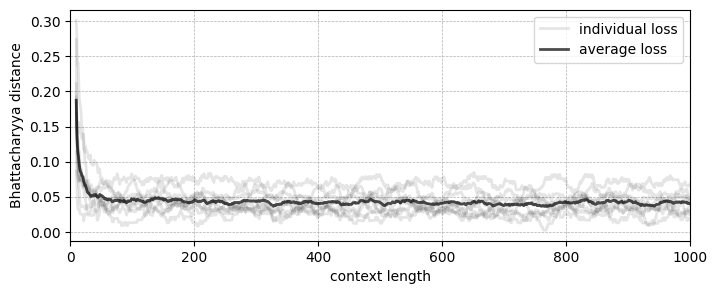

In [14]:
series_name = 'markov_chain_unigram'
x_range, avg_mean_loss, avg_BT_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 0,
                   processed_series=processed_series_for_baseline, legend = True)

fig_1_series[series_name] = (x_range[:1000], avg_BT_loss[:1000])
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

number of trajectories: 9


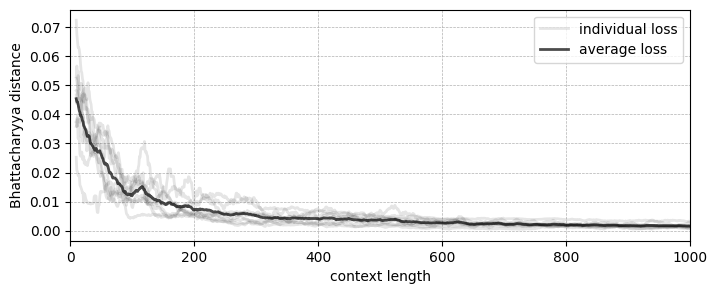

In [15]:
series_name = 'markov_chain_bigram'
x_range, avg_mean_loss, avg_BT_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 0,
                   processed_series=processed_series_for_baseline, legend = True)

fig_1_series[series_name] = (x_range[:1000], avg_BT_loss[:1000])
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_488676/3118360639.py:79: RuntimeWarning: divide by zero encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))
/tmp/ipykernel_488676/3118360639.py:79: RuntimeWarning: invalid value encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))


number of trajectories: 15


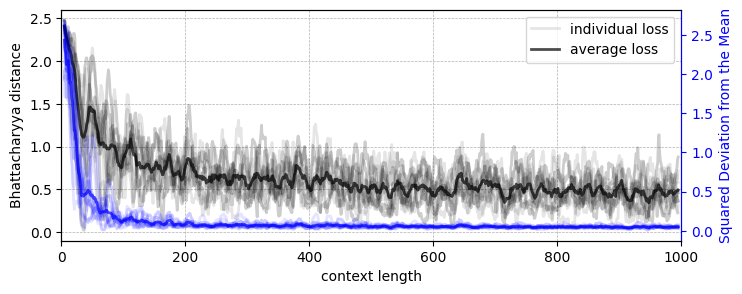

In [16]:
series_name = 'logistic_map'
x_range, avg_mean_loss, avg_BT_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 1,
                   processed_series=processed_series_for_baseline, legend = True)

fig_1_series[series_name] = (x_range, avg_mean_loss)

plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_488676/3118360639.py:79: RuntimeWarning: divide by zero encountered in divide
  return np.where(true_sigma == 0, np.where(x < true_mean, 0, 1), 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2)))))


number of trajectories: 12


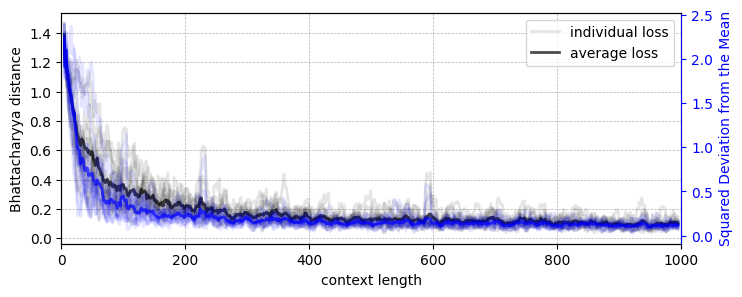

In [17]:
series_name = 'noisy_logistic_map_llama'
x_range, avg_mean_loss, avg_BT_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 1,
                   processed_series=processed_series_for_baseline, legend = True)

fig_1_series[series_name] = (x_range, avg_BT_loss)

plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


UnboundLocalError: cannot access local variable 'x_range' where it is not associated with a value

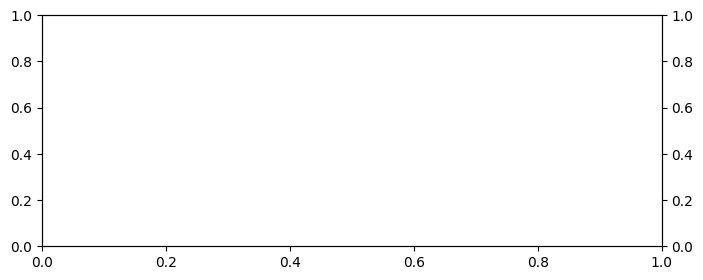

In [18]:
series_name = 'noisy_logistic_map_AR1'
x_range, avg_mean_loss, avg_BT_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   plot_mean = 1,
                   processed_series=processed_series_for_baseline, legend = True)

fig_1_series[series_name] = (x_range, avg_BT_loss)

plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')

In [19]:
ordered_series_names = ['markov_chain_llama_13b', 'markov_chain_unigram', 'markov_chain_bigram', 'logistic_map', 'noisy_logistic_map_llama', 'noisy_logistic_map_AR1']

from scipy.optimize import curve_fit

# Define the power-law function
def power_law(x, d_c, alpha):
    return x** alpha / d_c

# Initialize a dictionary to store the fitted lines
fitted_lines = {}
fitted_alphas = {}

# Loop over each series
for i, series_name in enumerate(ordered_series_names):
    x, y = fig_1_series[series_name]
    
    # Fit the power-law function to the data
    # if series_name in ['brownian_motion', 'geometric_brownian_motion']:
    if series_name is None:
        popt, pcov = curve_fit(power_law, x[:200], y[:200], maxfev=1000,p0 = np.asarray([5,-1]))
    else:
        popt, pcov = curve_fit(power_law, x, y, maxfev=1000,p0 = np.asarray([5,-1]))
    print(series_name)
    print(popt)
    print(pcov)
    # Generate the fitted line
    fitted_line = power_law(x, *popt)
    
    # Store the fitted line in the dictionary
    fitted_lines[series_name] = fitted_line
    fitted_alphas[series_name] = popt[1]
    

markov_chain_llama_13b
[ 3.65797298 -0.48170569]
[[2.28115740e-03 1.23728026e-04]
 [1.23728026e-04 7.27270351e-06]]
markov_chain_unigram
[10.39130087 -0.13666987]
[[7.26079258e-02 1.18474493e-03]
 [1.18474493e-03 1.99900256e-05]]
markov_chain_bigram
[ 3.29143119 -0.69499711]
[[3.40086426e-03 2.39784170e-04]
 [2.39784170e-04 1.86152653e-05]]
logistic_map
[ 0.07138125 -0.88286396]
[[2.76190074e-06 1.21909200e-05]
 [1.21909200e-05 6.26288168e-05]]
noisy_logistic_map_llama
[ 0.25906985 -0.5338359 ]
[[5.84238264e-06 4.86298978e-06]
 [4.86298978e-06 4.64481057e-06]]


KeyError: 'noisy_logistic_map_AR1'

### Master Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


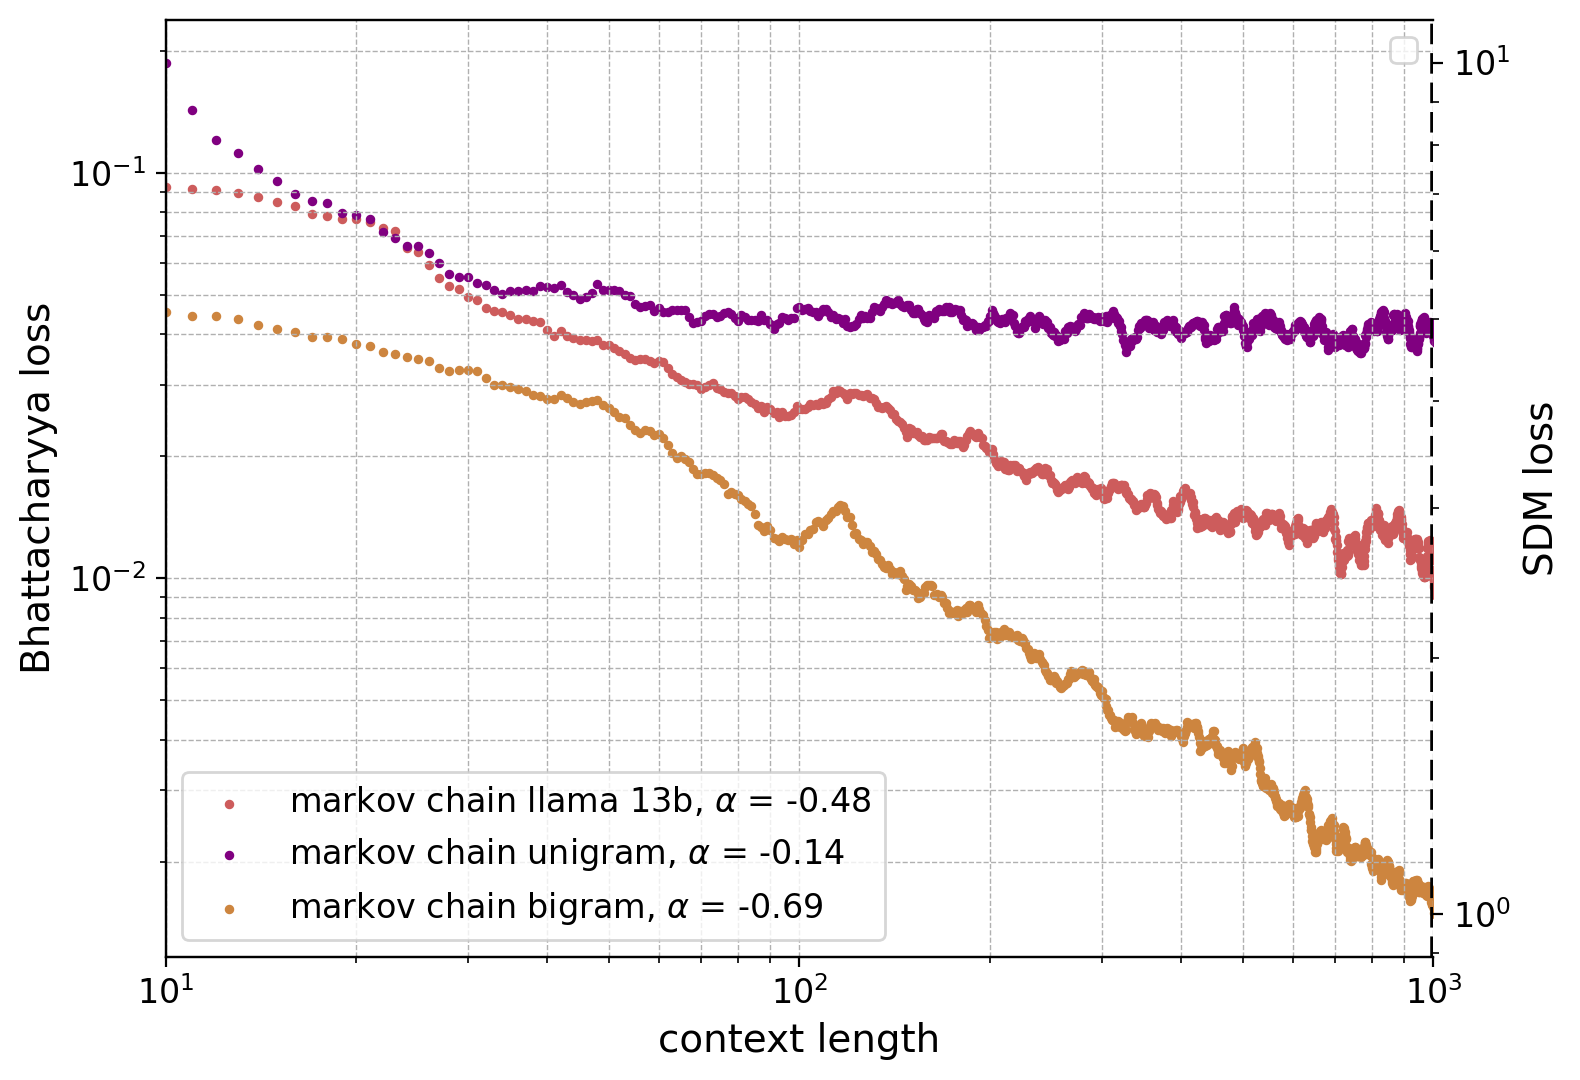

In [20]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Define line styles for different series
line_styles = ['solid', 'solid']
ordered_series_names = ['markov_chain_llama_13b', 'markov_chain_unigram', 'markov_chain_bigram']
# Define colors for different series
colors = ['indianred', 'purple', 'peru']

fig, ax1 = plt.subplots(figsize=(8, 5.5), dpi = 200)
ax2 = ax1.twinx()  # Create twin axis

power_fit = False

for i, series_name in enumerate(ordered_series_names):
    x, y = fig_1_series[series_name]
    y_fit = fitted_lines[series_name]
    alpha = fitted_alphas[series_name]
    label_str = rf"{series_name.replace('_', ' ')}, $\alpha$ = {alpha:.2f}"
    if line_styles[i % len(line_styles)] == 'solid':
        ax1.scatter(x, y, linewidth=2, s=2, label=label_str, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
        if power_fit:
            ax1.plot(x, y_fit, linewidth=2, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
    else:
        ax2.scatter(x, y, linewidth=2, s=2, label=label_str, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
        if power_fit:
            ax2.plot(x, y_fit, linewidth=2, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)



ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

# Set grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set labels with larger font size
ax1.set_xlabel("context length", fontsize=14)
ax1.set_ylabel("Bhattacharyya loss", fontsize=14)
ax2.set_ylabel("SDM loss", fontsize=14)

# Set legend inside the plot area
legend1 = ax1.legend(loc='lower left', fontsize=12)
legend2 = ax2.legend(loc='upper right', fontsize=12)

# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Overlay a dashed line on the right y-axis
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, color='k', linestyle='--', lw=2)

# Turn off the original right axis
ax2.spines['right'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(10,1000)
# Use tight layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(figure_save_path / "fig1.png", dpi=300, bbox_extra_artists=(legend1, legend2), bbox_inches='tight')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


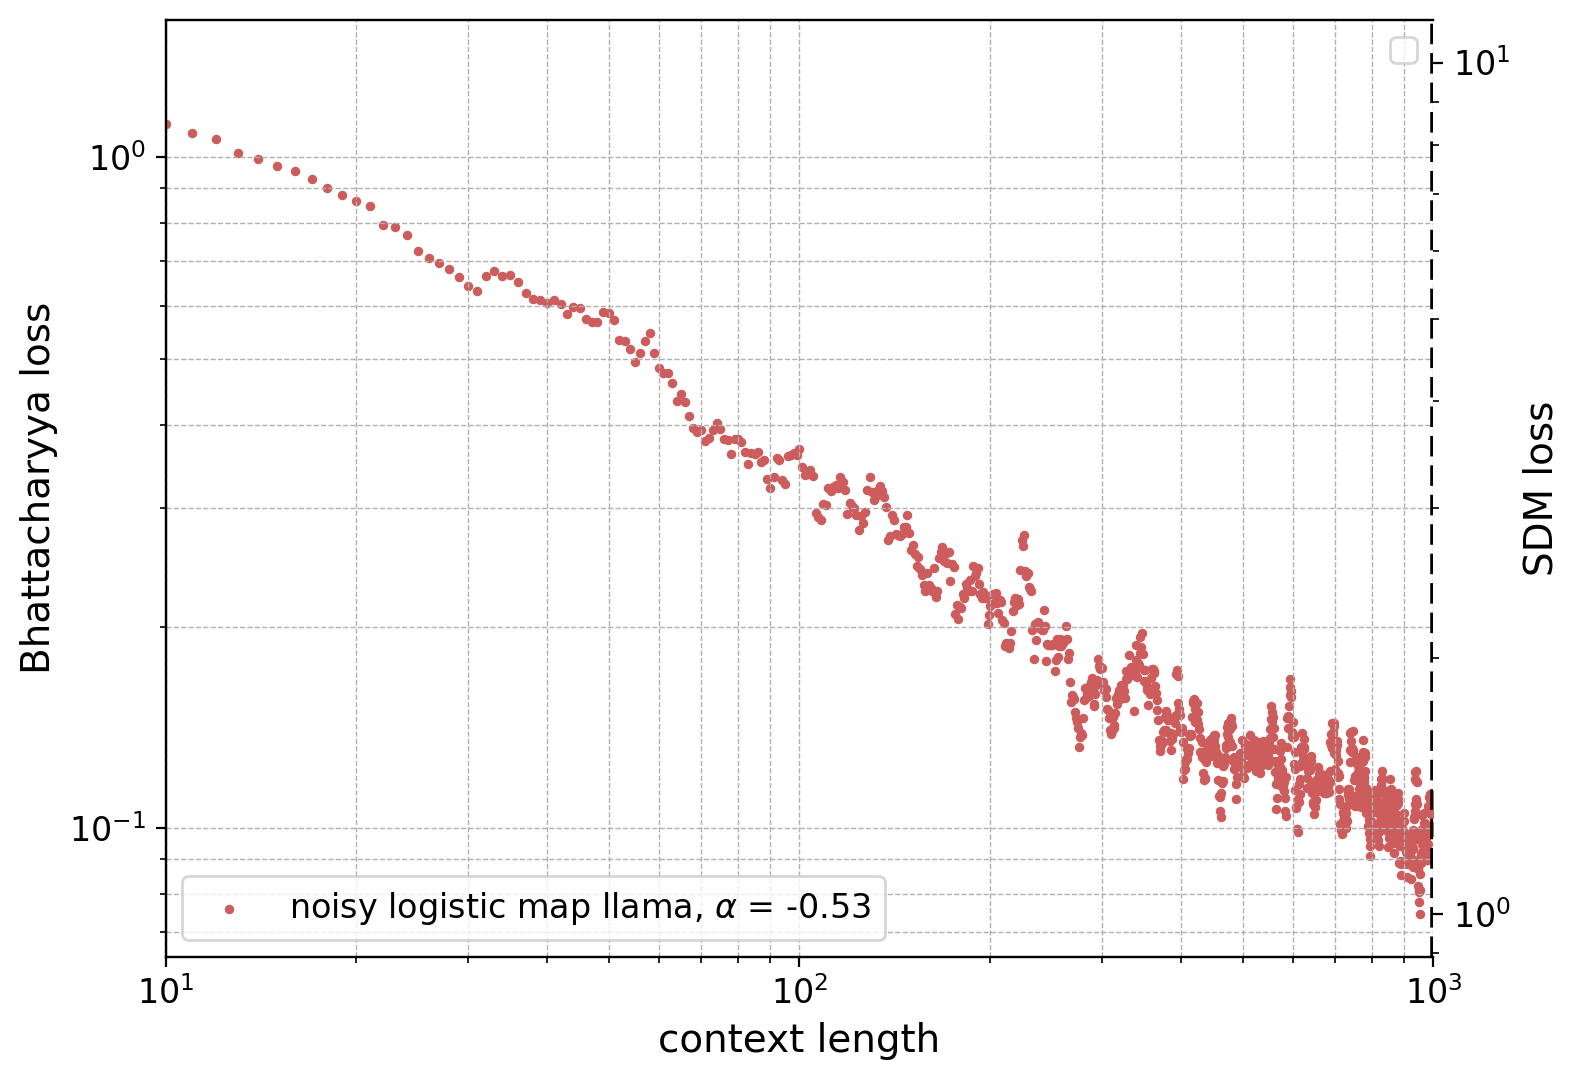

In [23]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Define line styles for different series
line_styles = ['solid', 'solid']
ordered_series_names = ['noisy_logistic_map_llama', 
                        # 'noisy_logistic_map_llama_AR1'
                        ]
# Define colors for different series
colors = ['indianred', 'purple']

fig, ax1 = plt.subplots(figsize=(8, 5.5), dpi = 200)
ax2 = ax1.twinx()  # Create twin axis

power_fit = False

for i, series_name in enumerate(ordered_series_names):
    x, y = fig_1_series[series_name]
    y_fit = fitted_lines[series_name]
    alpha = fitted_alphas[series_name]
    label_str = rf"{series_name.replace('_', ' ')}, $\alpha$ = {alpha:.2f}"
    if line_styles[i % len(line_styles)] == 'solid':
        ax1.scatter(x, y, linewidth=2, s=2, label=label_str, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
        if power_fit:
            ax1.plot(x, y_fit, linewidth=2, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
    else:
        ax2.scatter(x, y, linewidth=2, s=2, label=label_str, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
        if power_fit:
            ax2.plot(x, y_fit, linewidth=2, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)



ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

# Set grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set labels with larger font size
ax1.set_xlabel("context length", fontsize=14)
ax1.set_ylabel("Bhattacharyya loss", fontsize=14)
ax2.set_ylabel("SDM loss", fontsize=14)

# Set legend inside the plot area
legend1 = ax1.legend(loc='lower left', fontsize=12)
legend2 = ax2.legend(loc='upper right', fontsize=12)

# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Overlay a dashed line on the right y-axis
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, color='k', linestyle='--', lw=2)

# Turn off the original right axis
ax2.spines['right'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(10,1000)
# Use tight layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(figure_save_path / "fig1.png", dpi=300, bbox_extra_artists=(legend1, legend2), bbox_inches='tight')

plt.show()
